# Vector Fitting

Se p1 e p2 são um par complexo conjugado, então c1 e c2 também formar um par complexo conjugado, assim como d1 e d2. De forma com que $\theta$ passa a ser:
$$\theta = \begin{bmatrix} c_0 & \Re(c_1) & \Im(c_1) & \Re(d_1) & \Im(d_1) \end{bmatrix} $$
Quando isso ocorre, fazer uma substituição na matrix M de:
$$\frac{1}{S-p_1}$$
e
$$\frac{1}{S-p_2}$$
por:
$$\frac{1}{S-p_1}+\frac{1}{S-p_1^*}$$
e
$$\frac{j}{S-p_1}-\frac{j}{S-p_1^*}$$

# M
$$M =
\begin{bmatrix}
1 & \frac{1}{S_1-p_1}+\frac{1}{S_1-p_1^*} & \frac{j}{S_1-p_1}-\frac{j}{S_1-p_1^*} & -G(S_1)(\frac{1}{S_1-p_1}+\frac{1}{S_1-p_1^*}) & -G(S_1)(\frac{j}{S_1-p_1}-\frac{j}{S_1-p_1^*}) \\
1 & \frac{1}{S_2-p_1}+\frac{1}{S_2-p_1^*} & \frac{j}{S_2-p_1}-\frac{j}{S_2-p_1^*} & -G(S_2)(\frac{1}{S_2-p_1}+\frac{1}{S_2-p_1^*}) & -G(S_2)(\frac{j}{S_2-p_1}-\frac{j}{S_2-p_1^*}) \\
1 & \frac{1}{S_3-p_1}+\frac{1}{S_3-p_1^*} & \frac{j}{S_3-p_1}-\frac{j}{S_3-p_1^*} & -G(S_3)(\frac{1}{S_3-p_1}+\frac{1}{S_3-p_1^*}) & -G(S_3)(\frac{j}{S_3-p_1}-\frac{j}{S_3-p_1^*}) \\
1 & \frac{1}{S_4-p_1}+\frac{1}{S_4-p_1^*} & \frac{j}{S_4-p_1}-\frac{j}{S_4-p_1^*} & -G(S_4)(\frac{1}{S_4-p_1}+\frac{1}{S_4-p_1^*}) & -G(S_4)(\frac{j}{S_4-p_1}-\frac{j}{S_4-p_1^*}) \\
1 & \frac{1}{S_5-p_1}+\frac{1}{S_5-p_1^*} & \frac{j}{S_5-p_1}-\frac{j}{S_5-p_1^*} & -G(S_5)(\frac{1}{S_5-p_1}+\frac{1}{S_5-p_1^*}) & -G(S_5)(\frac{j}{S_5-p_1}-\frac{j}{S_5-p_1^*}) \\
\end{bmatrix}
$$

Com os d's e c's, vejo se os p's são reais ou pares complexos conjugados encontrando os zeros da função:
$$polos = zeros( 1+\sum\limits_{i=1}^{n}\frac{d_i}{S-p_i} ) $$
Encontrando os novos polos p para a nova iteração.

### Regra para encontrar os zeros

Construir as matrizes:

$$A = 
\begin{bmatrix}
p_1 & 0 & \cdots & 0\\
0 & p_2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & p_n\\
\end{bmatrix}
$$

$$B = 
\begin{bmatrix}
1\\
1\\
\vdots\\
1\\
\end{bmatrix}
$$

$$\tilde{D} = 
\begin{bmatrix}
d_1 & d_2 & \cdots & d_n 
\end{bmatrix}
$$

#### Caso $\Im(p_i) \not= 0$
Substitua as submatrizes:
$$\begin{bmatrix}
p_{i} & 0 \\
0 & p_{i+1}\\
\end{bmatrix}
$$
Por:
$$\begin{bmatrix}
\Re(p_{i}) & \Im(p_{i}) \\
-\Im(p_{i}) & \Re(p_{i})\\
\end{bmatrix}
$$
E:
$$\begin{bmatrix}
1\\
1\\
\end{bmatrix}
$$
Por:
$$\begin{bmatrix}
2\\
0\\
\end{bmatrix}
$$
Encontre os valores de p:
$$p=eig(A-B\tilde{D})$$
E se $\Re(p_i)>0$, fazer com que $p_i=-\Re(p_i)+\Im(p_i)$

## Conjunto de dados
- Trafo_345_225kV.mat
- n = 12

In [1]:
import numpy as np

In [753]:
import seaborn as sns
from matplotlib import pyplot as plt

In [293]:
with open('aula_04.csv') as f:
    data = f.read()
data = data.split()
data = np.array(list(zip(*[list(map(complex,x.split(';'))) for x in data])))
u = data[0,:].real
y = data[1,:]

In [1050]:
def gen_r(u, y, i, p, is_complex):
    p, pp = p[i], p[i-1]

    if not is_complex:
        return 1/(u-p)

    real = not i%2
    if is_complex and real:
        return 1/(u-p)+1/(u-p.conj())

    return 1j/(u-pp)-1j/(u-pp.conj())

In [1051]:
def gen_d(u, y, i, p, is_complex):
    p, pp = p[i], p[i-1]
    
    if not is_complex:
        return -y*1/(u-p)

    real = not i%2
    if is_complex and real:
        return -y*(1/(u-p)+1/(u-p.conj()))

    return -y*(1j/(u-pp)-1j/(u-pp.conj()))


In [1052]:
def fun_is_complex(p):
    return np.logical_or(
        np.concatenate([[False],np.where(p[1:].imag!=0, True, False)]),
        np.where(p.imag!=0, True, False)
        ).reshape(-1,1)

In [1220]:
def lsqr_complex_polinomial_vf(u, y, n=2, p=None):
    amostras = u.size
    params = 2*n+1

    if p is None:
        p = np.zeros(n)
    
    is_complex = fun_is_complex(p)
    
    M = np.ones((amostras, params), dtype=complex)

    for i in range(n):
        M[:,i+1] =   gen_r(u, y, i, p, is_complex[i])
        
    for i in range(n):
        M[:,i+1+n] = gen_d(u, y, i, p, is_complex[i])

    M = np.concatenate([M.real, M.imag])
    y_tilde = np.concatenate([y.real, y.imag])

    theta = np.linalg.inv(M.T.dot(M)).dot(M.T).dot(y_tilde)

    y_hat_tilde = np.sum(M*theta.T,axis=1)

    y_hat = y_hat_tilde[:amostras]+1j*y_hat_tilde[amostras:]

    return y_hat, theta, is_complex

In [1265]:
def nmse_error(y, y_hat):
    nmse = 10*np.log10(
        np.sum(np.abs(y-y_hat)**2)/
        np.sum(np.abs(y)**2)
        )
    return nmse

In [1280]:
n = 2
p = np.array([-0.1+10j, -0.1-10j])

[[False]
 [False]]


-1.775640096529605

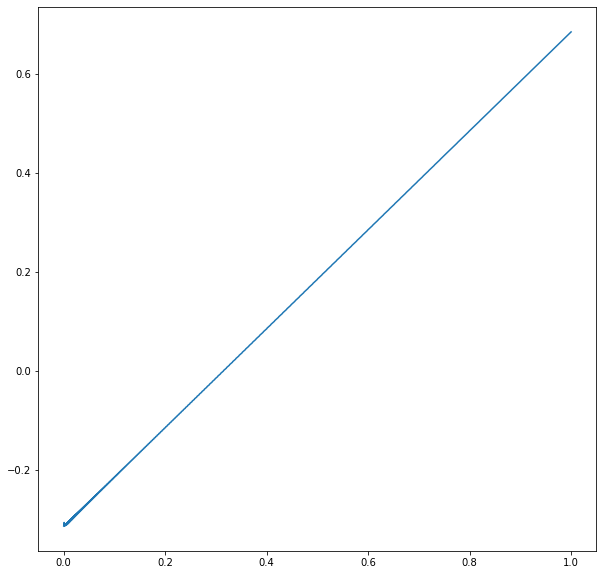

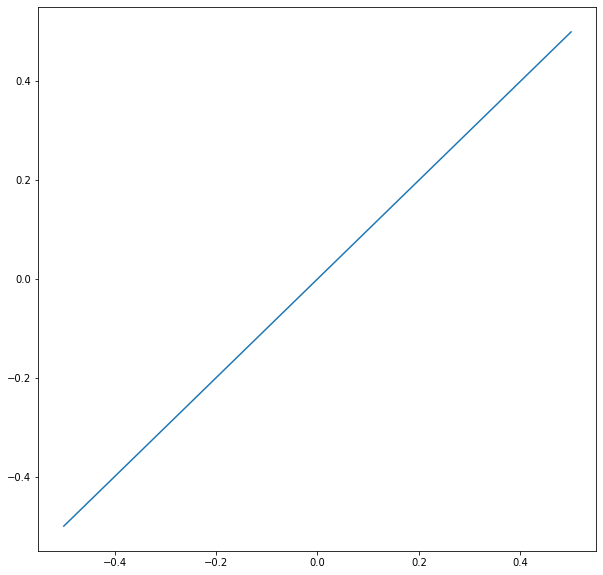

In [1294]:
y_hat, theta, is_complex = lsqr_complex_polinomial_vf(u,y,n=n,p=p)
print(is_complex)

A = np.diagflat(p)
B = np.ones(n)
C = theta[-n:]+0j

for i, c in enumerate(is_complex):
    if i==n-1 and not i%2:
        is_complex[i] = False
        #C[i] = np.abs(C[i])
    if c and not i%2:
        A[i:i+2,i:i+2] = np.array([[p[i].real, p[i].imag],[-p[i].imag, p[i].real]])
        B[i:i+2] = [2, 0]
        #C[i:i+2] = [C[i]+1j*C[i+1], C[i]-1j*C[i+1]]

#B = B.reshape(-1,1)
#C = C.reshape(1,-1)

p = np.linalg.eigvals(A-B.dot(C))
p = -np.abs(p.real)+1j*p.imag

plt.figure(figsize=(10,10))
sns.lineplot(x=y.real, y=y_hat.real)
plt.figure(figsize=(10,10))
sns.lineplot(x=y.imag, y=y_hat.imag)
nmse_error(y, y_hat)

In [1251]:
B.dot(C)

(-5156.97001203552-59659.57409621407j)

In [1252]:
A

array([[-2580.40908333+0.j,  9193.78841874+0.j],
       [-9193.78841874+0.j, -2580.40908333+0.j]])

In [1255]:
p

array([-7673.79480119+120018.31812122j, -2520.67294378   -699.16992879j])

In [1254]:
theta

array([ 3.41027673e+00, -8.79843708e+03, -1.01845746e+05, -2.57848501e+03,
       -2.98297870e+04])